In [1]:
import sys
import numpy as np 
import scipy as sp
import sympy 
import dataclasses
import control as ct
from typing import Optional
import pandas as pd

# other files I created 
import header
import linearize
import initialize
import kalmanFilter as kf
import simMeasurements as sm

### The Dynamics and Measurement Model

The phase will be estimated by the following process: 

> $\phi_{k} = \phi_{0} + 2\pi(f_{d,k}kTs + \frac{1}{2} \dot{f}_{d,k} k^2 Ts^2)$

Wherever we estimate a parameter, we incur a noise term on that estimate. The IMU will be reporting the observer velocity, $v_0$, but will impart a biased noise term, $\eta_{IMU}$, onto it. Accounting for this in the traditional doppler frequency equation yields:  

> ### $\hat{f}_d = \frac{v+v_0+\eta_{IMU}}{v+v_s} + \eta_{clock}$
Where $\hat{f}_d$ is the doppler estimate, $v$ is the speed of sound, $v_s$ is the signal source velocity, and $\eta_{clock}$ is the clock process noise.

This requires an estimate of the user velocity from the IMU. The equation used here will be: 

> $\dot{v}^n = f^n -(\Omega^{n}_{e/n} + 2 \Omega^{n}_{i/e})v^n + g^n$

We will make the assumption of 1D velocity, constant angular position states: 

> $\dot{v}^n = f^n -(2 \Omega^{n}_{i/e})v^n + g^n$
>> biased accelerometer output: $f^n = f + b + \omega_{IMU}$

Here, $\eta_{clock}$ will be a white, thermal noise source. However, the IMU noise will be biased and will require some dynamic model.  

How to I model $\eta_{IMU}$? 

#### FW difference FOGMP model: 

>$b_{k} = b_{k-1} + k*Ts*\dot{b}_{k-1} = b_{k-1} + \frac{k*Ts}{\tau}(b_{k-1} + \omega) = (1+\frac{k*Ts}{\tau})b_{k-1} + \frac{k*Ts}{\tau}*\omega$
>> ... $b_{k} = (1+\frac{k*Ts}{\tau})b_{k-1} + \frac{k*Ts}{\tau}*\omega_{k-1}$

#### Dynamic model in continuous time 
> $ \begin{pmatrix} \dot{\theta} \\ \dot{f}_d \\ \dot{v} \\ \dot{b} \end{pmatrix} = \begin{pmatrix}  f_d \\ \frac{d}{dt} (\frac{\nu + v}{\nu + v_s}) \\ f + b - 2\Omega^{2}_{i/e}v + g\\ \frac{1}{\tau}b \end{pmatrix} + \begin{pmatrix} \omega_{LO} \\ 0 \\ \omega_v \\ \omega_{IMU}\end{pmatrix}$

Where the phase is given by the accuulation of the frequency $f(t)$ and the original phase: 

>$ \theta = \theta_0 + \int^{t}_{t_0} f(t) dt$

$f(t)$ should be the result of the doppler shift of the incoming signal.

Note here that the $\dot{f}_d$ state is redundant. We can directly substitute it in for the $\dot{\theta}$ equation: 

> $ \begin{pmatrix} \dot{\theta} \\ \dot{v} \\ \dot{b} \end{pmatrix} = \begin{pmatrix}  \frac{\nu + v}{\nu + v_s} \\ f + b - 2\Omega^{2}_{i/e}v + g\\ \frac{1}{\tau}b\end{pmatrix} + \begin{pmatrix} \omega_{LO}\\ \omega_v \\ \omega_{IMU}\end{pmatrix}$

or, separating states, control inputs, and noise termns (and adding the local clock phase noise)

> $ \begin{pmatrix} \dot{\theta} \\ \dot{v} \\ \dot{b} \end{pmatrix} = \begin{bmatrix} 0 & \frac{1}{v_d + v_s} & 0 \\ 0 & -2\Omega^{2}_{i/e} & 1 \\ 0 & 0 & \frac{1}{\tau} \end{bmatrix} \begin{pmatrix} \theta \\ v \\ b \end{pmatrix} + \begin{bmatrix} 0 & 0 & 1 \\ 1 & 1 & 0 \\ 0& 0 & 0 \end{bmatrix} \begin{pmatrix} f \\ g \\ \frac{v_d}{v_d+v_s} \end{pmatrix} + \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix} \begin{pmatrix} \omega_{LO} \\ \omega_{v} \\ \omega_{IMU} \end{pmatrix}$

Note that the speed of sound is now represented as $v_d$ since $\nu$ is typically reserved for measurement noise (up next).

The system will use the following measurement model: 

> $z = \begin{pmatrix} z_I \\ z_Q \end{pmatrix} = \begin{pmatrix} a*cos(\theta) \\ a*sin(\theta) \end{pmatrix} + \nu_k$

Where $a$ is the signal amplitude, $z_I$ and $z_Q$ represent the in phase and quadrature sample of the incoming signal, repectively. 

The estimation of the signal amplitude will require a state augmentation. We will assume amplitude constancy as a dynamic model.

After linearization, the measurement model will be: 

> $z-z(a^*,\theta^*) = \begin{bmatrix} -a*sin(\theta^*) & 0 & 0 &  cos(\theta^*) \\ a*cos(\theta^*) & 0 & 0 & sin(\theta^*)\end{bmatrix} (x-x^*) + \nu $
>> == $z_{k}^{*}+H_{k}^{*}x^*= H_{k}^{*}x +\nu_k$

where all $(.)^*$ values come from some nominal trajectory and the state-space system becomes:

> $\begin{pmatrix} \dot{\theta} \\ \dot{v} \\ \dot{b} \\ \dot{a} \end{pmatrix} = \begin{bmatrix} 0 & \frac{1}{v_d + v_s} & 0 & 0 \\ 0 & -2\Omega^{2}_{i/e} & 1 & 0 \\ 0 & 0 & \frac{1}{\tau} & 0 \\ 0 & 0 & 0 & 0 \end{bmatrix} \begin{pmatrix} \theta \\ v \\ b \\ a \end{pmatrix} + \begin{bmatrix} 0 & 0 & 1 \\ 1 & 1 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & 0  \end{bmatrix} \begin{pmatrix} f \\ g \\ \frac{v_d}{v_d+v_s} \end{pmatrix} + \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \\ 0 & 0 & 0 \end{bmatrix} \begin{pmatrix} \omega_{LO} \\ \omega_{v} \\ \omega_{IMU} \end{pmatrix}$ 

### Code implementation

In [2]:
# stocastic information 
sigma_nu = 5                                    # measurement noise standard deviation (SD)
sigma_v  = 3                                    # velocity measurement SD
sigma_theta = np.pi                             # phase measurement SD
sigma_b = 2                                     # accelerometer bias SD 
sigma_omega_IMU = 2                             # accelerometer noise SD
sigma_omega_clock = 2                           # local ascillator phase noise SD 
sigma_omega_v = 2                               # non-IMU related process noise on velocity state
P0 = np.diag([sigma_theta**2, sigma_v**2, sigma_b**2])                      # initial state covariance 
W  = np.diag([sigma_omega_IMU**2, sigma_omega_clock**2, sigma_omega_v**2])  # process noise covariance 
V  = np.diag([sigma_nu**2,sigma_nu**2])         # measurement noise covariance 

# system variables 
a, theta, v, b = sympy.symbols('a theta v b')   # all unknowns in system which may be 'lambdafied'
vars = list([theta, v, b])                      # variable representation of states
v_d = 343                                       # speed of sound in dry air in m/s
v_0 = 5                                         # initial magnitude of velocity 
f_d0 = 10                                       # initial doppler frequency in Hz
v_s = (v_d+v_0)/f_d0 - v_d                      # solving for initial satellite velocity in m/s. This will be estimated later.
omega_e = 1.99*(10**-7)                         # angular velocity of earth in rad/s 
tau = 1                                         # time constant of accelerometer bias 
phi_0 = np.pi/2                                 # initial phase offset of incoming signal

# simulation settings 
Ts = 10                                         # sample time in Hz
Tc = .02                                        # coherent integration time in seconds 
st = 60                                         # requested simulation runtime in seconds 

In [3]:
# measurements 
# linearize the observation matrix 
H = sympy.Matrix([[a*sympy.sin(theta)],[a*sympy.cos(theta)]])           # observation matrix 
dH, varsa = linearize.linearize(H, vars, (H.shape[0],len(vars)))
D = sympy.diag(1,1)

# dynamics -> note that this system will not be linear after estimating v_s 
A = sympy.Matrix([[0, 1/(v_d+v_s),0],[0,-2*omega_e**2,1],[0,0,1/tau]]) # state transition matrix
nx = A.shape[0]                                    # number of states must match columns of A 
B = sympy.Matrix([[0,0,1],[1,1,0],[0,0,0]])                            # control input matrix (sparse)
nu = B.shape[1]
G = sympy.Matrix([[1,0,0],[0,1,1],[0,0,1]])             # process noise input matrix
ng = G.shape[1]         # number of noise variables must match the colummns of G 

# store all system information in a dataclass 
sys = header.SymSystem(A, B, G, dH, D) # NOTE that dH is linearized, and the states there are defined by 
                                       # their deviation from some nominal value 

#### The Kalman Filter 

The Kalman filter will require: 
- The system dynamics (we will use a header.SymSystem type)
- The measurement model (same type as above)
- The system statistics, which includes: 
    - The variances of all states and noise sources 
    - The initial covariance and MAP estimates of the states 
- A trajectory to linearize off of in the case of out non-linear dynamics 

In [4]:
# the Kalman filter args look like this: 
# def KalmanFilter(sys: h.SymSystem, init_args: dict, traj: np.ndarray, stats: dict):
# we will package our information to suit this

###### The init_args ######
# sys is defined above 
initials = np.array([np.pi/2+.001, 10, .001, 1, np.pi/2])
initials = np.transpose(initials)
var_list = list([theta, v, b, a, phi_0])
feilds = list(["A", "B", "G", "C", "D"]) # form elements of control system
init_args_keys = list(["sys","initials","var_list","fields"])
init_arg_fields = list([sys, initials, var_list, feilds])
init_args = dict.fromkeys(init_args_keys)
i = 0
for key in init_args_keys:
    init_args[key] = init_arg_fields[i]
    i = i + 1

###### The statistics of the system, 'stats' ######
# initial states 
theta0 = phi_0 + .001       # unitless    
v = 10                      # m/s
bias0 = .0001                # m/s 
x0    = np.transpose(np.array([theta0, v, bias0]))
stats_keys = list(["P0", "x0", "W", "V"])
fields = list([P0, x0, W, V])
stats = dict.fromkeys(stats_keys)
i = 0
for keys in stats_keys:
    stats[keys] = fields[i]
    i = i + 1

In [5]:
# discrete form of symbolic system via ZOH  
# TODO replace with Van Loans
B = sys.B
A = sys.A
dt = Ts**-1
nx, nm = sys.B.shape
Phik = sympy.exp(A*dt)
GamUk = dt*B + ((dt**2)/2)*A*B + ((dt**3)/6)*A*A*B # using approximation since A is not invertible
#GWG = sympy.exp(sys.A*1/Ts)*sys.G*W*np.transpose(sys.G)*sympy.exp(sys.A*1/Ts)*1/Ts # only used for exactness 
GamWk = sys.G*1/Ts # usable for sufficiently small sample times 
# GamWk_test = sympy.exp(sys.A*1/Ts)*sys.G * 1/Ts # slightly more accurate version? 
args = [Phik,GamUk,GamWk,sys.C,sys.D]
sysd = header.SymSystem(*args)
init_args["sys"] = sysd

# TODO this is supposedly an accurate way to compute Phik and GamUk, but GamUk was coming out VERY wrong
# M = sympy.Matrix(np.zeros((nx+nm,nx+nm)))
# M[0:nx,0:nx] = sys.A
# M[0:nx,nx:nx+sys.B.shape[1]] = sys.B
# dmats = sympy.exp(M*(1/Ts)) 
# Phik = dmats[0:nx,0:nx]
# GamUk = dmats[0:nx,nx:] # TODO not correct 


In [6]:
# we're almost ready to pass this to the kalman filter, but we'll need a trajectory to linearize the system with. 
# this is a case-by-case tool, so it will require a redo for each situation we wish to face.
traj: float = np.matrix(np.zeros((nx,int(st*Ts))))
u: float    = np.matrix(np.zeros((nu,int(st*Ts))))
v_k = 0
phi_nom = np.pi/2 # nominal phase value
v_ts = np.matrix([[phi_nom],[v_k],[0]]) 
v_nom= sys.A[1,:]*v_ts
b_nom = 0.0 # nominal bias value will be zero 
init_args_hold = init_args
for i in range(0,int(st*Ts),1):
    u[:,i] = np.matrix([[1+np.random.randn()],[9.81],[v_d/(v_d+v_s)]])
for i in range(1,int(st*Ts),1):
    sysd_hold = initialize.initialize(init_args_hold)
    traj[:,i] = np.matrix([[phi_nom],[v_nom[0,0]],[0]], dtype=float)
    u_nom = u[1,i]
    v_nom = sysd_hold.A[1,:]*np.matrix([[phi_nom],[v_nom[0,0]],[b_nom]], dtype=float)+u_nom
    if i != int(st*Ts):
        fill: float = np.matrix([[1],[np.pi/2]])
        initals_hold: float = np.array(np.concatenate((traj[:,i],fill), axis=0))
        init_args_hold["initials"] = initals_hold

In [7]:
# run kalman filter 
x, P, Pbar, K_list, H_list, Phi_list = kf.KalmanFilter(sysd, init_args, traj, stats, Ts, st, u,"R")

In [8]:
n = nx
m = dH.shape[0]
exc = np.matrix([[1],[1],[1]])
for i in range(1,int(st*Ts)-1,1):
    Pp = Pbar[:,i*n:(i+1)*n]
    H = H_list[:,i*n:(i+1)*n]
    K = K_list[:,i*m:(i+1)*m]
    A = Phi_list[:,i*n:(i+1)*n]
    exc = (np.eye(nx,nx)-K*H)*A

In [9]:
zk = np.array(pd.read_csv('zk.csv'))
x = np.array(x)
P_tmp = np.array(P)
u_tmp = np.array(u)

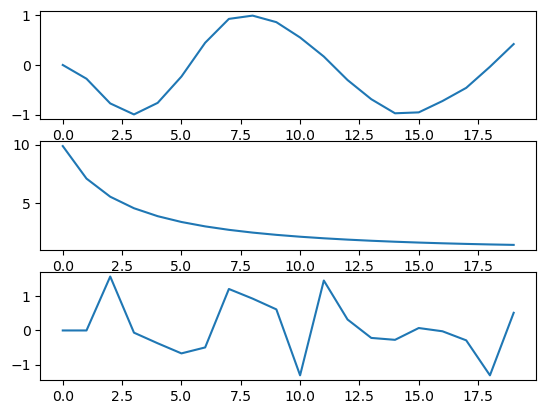

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3)
P_theta = P[0,:]
P_theta = P_theta[0,::3]
sig_theta = np.sqrt(P_theta)
xplt = x[0,0:20]
k = range(0,xplt.size,1)

ax[0].plot(k,np.cos(xplt))
ax[1].plot(k,np.transpose(P_theta[0,0:20]))
ax[2].plot(k,zk[0,0:20])

plt.show()

#### Reconstruct the Signal 

The results of the correlations here are 
> $sI = \sqrt{C}x(t-T)cos(2\pi \Delta f_d t + \Delta \theta)$

> $sQ = \sqrt{C}x(t-T)sin(2\pi \Delta f_d t + \Delta \theta)$

where 

> $\Delta f_d = f_d - \hat{f}_d$

> $\Delta \theta = \theta_0 - \hat{\theta}$ 

Here, $f_d$ is the real signal's doppler frequency, $\hat{f}_d$ is our best estimate of the real signal doppler frequency, $\theta_0$ is the real signal's original phase offset, and $\hat{\theta}$ is our best estimate of the real signal's original phase offset. $C$ is the real signal's power and $x(t-T)$ is the spreading code with its repective time delay. 

In [11]:
# reconstruct original signal 

# the phase and user velocity, combined with knowledge of the doppler equation, are sufficent to recover our signal. 
a = 1 
sI = a*np.cos(xplt) 
sQ = a*np.sin(xplt)
srms = np.mean(sI**2 + sQ**2) # signal power metric

